In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [285]:
import json
with open('../constants/hero_names.json') as _f:
    h_names = json.load(_f)
'http://cdn.dota2.com'
heros = {v['id']: v['localized_name'] for v in h_names.values()}

In [5]:
with open('../crawl/ref/match_id_nolimit') as file_:
    content = []
    for _row in file_.readlines():
        _content = _row.strip('\n').split(', ')[2]
        content.append(_content)

In [412]:
idx = np.random.permutation(len(content))
content = [content[i] for i in idx]
test_size = 1000
test_id = np.random.randint(len(content), size=test_size)
tr_id = [i for i in range(len(content)) if i not in test_id]
content_test = [content[i] for i in test_id]
content_tr = [content[i] for i in tr_id]

In [413]:
h0 = np.zeros((114))


def parse(_c):
    [tw, tl] = _c.split('>')
    hw = np.zeros((114))
    hl = np.zeros((114))
    hw[[int(h) for h in tw.split(':')]] = 1
    hl[[int(h) for h in tl.split(':')]] = 1
    return hw, hl

def data_gen(batch_size):
    i = 0
    while True:
        h1 = np.zeros((batch_size, 114))
        h2 = np.zeros((batch_size, 114))
        win = np.zeros((batch_size, 1))
        for j in range(batch_size//2):
            _c = content_tr[(i + j) % len(content_tr)]
            hw, hl = parse(_c)
            h1[2*j, :] = hw
            h2[2*j, :] = hl
            win[2*j, 0] = 1
            h1[2*j+1, :] = hl
            h2[2*j+1, :] = hw
        i += 1
        
        idx = np.random.permutation(batch_size)
        yield h1[idx,:], h2[idx,:], win[idx]

def test_data():
    h1 = np.zeros((test_size, 114))
    h2 = np.zeros((test_size, 114))
    win = np.zeros((test_size, 1))
    for j in range(test_size//2):
        _c = content_test[(i + j) % len(content_test)]
        hw, hl = parse(_c)
        h1[2*j, :] = hw
        h2[2*j, :] = hl
        win[2*j, 0] = 1
        h1[2*j+1, :] = hl
        h2[2*j+1, :] = hw
    return h1, h2, win

In [400]:
tf.reset_default_graph()
h1 = tf.placeholder(shape=(None, 114), dtype='float32')
h2 = tf.placeholder(shape=(None, 114), dtype='float32')
win = tf.placeholder(shape=(None, 1), dtype='float32')

NN_get_vec = [32, 8]
NN_cb = [8]
if_training = tf.placeholder(tf.bool, [])
dropout_rate = tf.placeholder(tf.float32, [])
def network_gen(_N_hu, _in_dim, _out_dim, x_in, name):
    for layer, n_units in enumerate(_N_hu + [_out_dim]):
        with tf.variable_scope(name + '_layer_' + str(layer)) as scope:
            if layer == 0:
                n_in = _in_dim
                _in = x_in
            else:
                n_in = _N_hu[layer - 1]
                _in = _out

            n_out = n_units

            W = tf.get_variable(name='W', initializer=tf.random_uniform([n_in, n_out], minval=-1, maxval=1))
            tf.add_to_collection('regularizer', tf.nn.l2_loss(W))
            b = tf.get_variable(name='b', initializer=tf.random_uniform([n_out], minval=-1, maxval=1))
            tf.add_to_collection('regularizer', tf.nn.l2_loss(b))
            Wxb = tf.matmul(_in, W) + b
            Wxb = tf.cond(if_training, 
                lambda: tf.contrib.layers.batch_norm(Wxb,
                                                     is_training=True,
                                                     scale=True,
                                                     reuse=None,
                                                     updates_collections=None,
                                                     scope=scope),
                lambda: tf.contrib.layers.batch_norm(Wxb,
                                                     is_training=False,
                                                     scale=True,
                                                     reuse=True,
                                                     updates_collections=None,
                                                     scope=scope))
            if layer == len(_N_hu):
                _out = Wxb
            else:
                # _out = tf.maximum(0.1*Wxb, Wxb)  # Leaky Relu
                _out = tf.nn.elu(Wxb)
                _out = tf.nn.dropout(_out, keep_prob=1 - dropout_rate)
            _out = tf.identity(_out, name="out")
    return _out

with tf.variable_scope('full') as scope:
    t1 = network_gen(NN_get_vec, 114, 4, h1, 'Get_Vec')
    scope.reuse_variables()
    t2 = network_gen(NN_get_vec, 114, 4, h2, 'Get_Vec')
combined = tf.concat([t1, t2], axis=1)
lr_out = network_gen(NN_cb,
                     8, 1,
                     combined, name='cb')

# y_hat = tf.minimum(tf.maximum(lr_out, 0), 1)
y_hat = tf.sigmoid(lr_out)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=lr_out, labels=win))

train_step = tf.train.RMSPropOptimizer(0.001).minimize(loss)


In [416]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) 
gen = data_gen(2000)

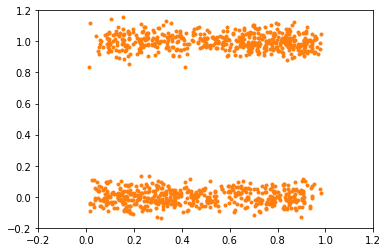

0.479446
0.793601


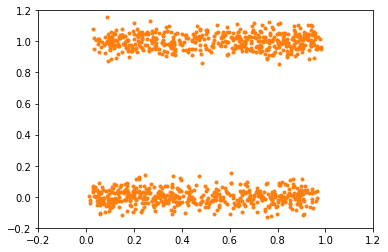

0.480391
0.837056


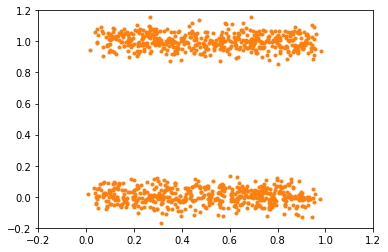

0.476812
0.879347


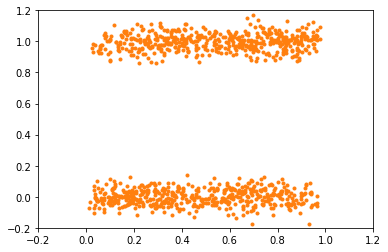

0.480658
0.792774


In [417]:
def visualize(var, data_feed, plot_sum=False, T=True):
    var_ = sess.run(var, feed_dict=data_feed)
    if plot_sum:
        plt.plot(np.absolute(var_).sum(axis=0), '.')
        plt.show()
    var_ = var_.T if T else var_
    plt.matshow(var_, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.show()
    
n_iters = 1000
for i in range(n_iters):
    d_h1, d_h2, d_win = next(gen)
    data_feed = {
        h1: d_h1,
        h2: d_h2,
        win: d_win,
        if_training: True,
        dropout_rate: 0.3
    }
    sess.run(train_step, feed_dict=data_feed)
    if i == 0 or (not (i % (n_iters//3))):
        d_h1, d_h2, d_win = test_data()
        data_feed_t = {
            h1: d_h1,
            h2: d_h2,
            win: d_win,
            if_training: False,
            dropout_rate: 0
        }
        y_predicted = sess.run(y_hat, feed_dict=data_feed_t)
        y_true = sess.run(win, feed_dict=data_feed_t)
        plt.plot(y_predicted,  np.random.normal(y_true, scale=0.05), '.', color='C1')
        plt.ylim(-0.2, 1.2)
        plt.xlim(-0.2, 1.2)
        plt.show()
        print(sess.run(loss, feed_dict=data_feed))
        print(sess.run(loss, feed_dict=data_feed_t))
        
        # visualize(combined, data_feed_t, T=True) 

In [115]:
np.where(d_h2[0] == 1)

(array([ 3,  6, 20, 39, 53]),)

In [418]:
def test_1(t1_heros, t2_heros):
    _h1 = np.zeros((1, 114))
    _h2 = np.zeros((1, 114))
    _h1[0, [h for h in t1_heros]] = 1
    _h2[0, [h for h in t2_heros]] = 1
    _data = {
        h1: _h1,
        h2: _h2,
        if_training: False,
        dropout_rate: 0
    }
    return sess.run(y_hat, feed_dict=_data)

def tell(draft1, draft2):
    r = test_1(draft1, draft2)
    if r > 0.5:
        print([heros[d] for d in draft1], '>', [heros[d] for d in draft2])
        print(r)
    else:
        print([heros[d] for d in draft1], '<', [heros[d] for d in draft2])
        print(r)
        
tell([53,68,63,16,40], [27, 78, 86, 69, 106])

["Nature's Prophet", 'Ancient Apparition', 'Weaver', 'Sand King', 'Venomancer'] < ['Shadow Shaman', 'Brewmaster', 'Rubick', 'Doom', 'Ember Spirit']
[[ 0.00107761]]


In [427]:
# draft2 = [20, 39, 47, 85, 106]
# draft2 = [1, 17, 67, 48, 44]
def rand_draft():
    draft1 = np.random.randint(1, 113, size=5).tolist()
    while 24 in draft1:
        draft1 = np.random.randint(1, 113, size=5).tolist()
    return draft1

t = 0
# draft1 = rand_draft()
while t < 10000:
    draft0 = rand_draft()
    if test_1(draft1, draft0) > 0.5:
        draft1 = draft0
    t += 1

In [432]:
saver = tf.train.Saver()
save_path = saver.save(sess, "model.ckpt")

In [443]:
[x.name for x in tf.global_variables()]

['full/Get_Vec_layer_0/W:0',
 'full/Get_Vec_layer_0/b:0',
 'full/Get_Vec_layer_0/beta:0',
 'full/Get_Vec_layer_0/gamma:0',
 'full/Get_Vec_layer_0/moving_mean:0',
 'full/Get_Vec_layer_0/moving_variance:0',
 'full/Get_Vec_layer_1/W:0',
 'full/Get_Vec_layer_1/b:0',
 'full/Get_Vec_layer_1/beta:0',
 'full/Get_Vec_layer_1/gamma:0',
 'full/Get_Vec_layer_1/moving_mean:0',
 'full/Get_Vec_layer_1/moving_variance:0',
 'full/Get_Vec_layer_2/W:0',
 'full/Get_Vec_layer_2/b:0',
 'full/Get_Vec_layer_2/beta:0',
 'full/Get_Vec_layer_2/gamma:0',
 'full/Get_Vec_layer_2/moving_mean:0',
 'full/Get_Vec_layer_2/moving_variance:0',
 'cb_layer_0/W:0',
 'cb_layer_0/b:0',
 'cb_layer_0/beta:0',
 'cb_layer_0/gamma:0',
 'cb_layer_0/moving_mean:0',
 'cb_layer_0/moving_variance:0',
 'cb_layer_1/W:0',
 'cb_layer_1/b:0',
 'cb_layer_1/beta:0',
 'cb_layer_1/gamma:0',
 'cb_layer_1/moving_mean:0',
 'cb_layer_1/moving_variance:0',
 'cb_layer_2/W:0',
 'cb_layer_2/b:0',
 'cb_layer_2/beta:0',
 'cb_layer_2/gamma:0',
 'cb_layer_2

In [445]:
cb0_W = tf.get_default_graph().get_tensor_by_name('cb_layer_0/W:0')
cb0_b = tf.get_default_graph().get_tensor_by_name('cb_layer_0/b:0')
cb1_W = tf.get_default_graph().get_tensor_by_name('cb_layer_1/W:0')
cb1_b = tf.get_default_graph().get_tensor_by_name('cb_layer_1/b:0')

ft0_W = tf.get_default_graph().get_tensor_by_name('full/Get_Vec_layer_0/W:0')
ft0_b = tf.get_default_graph().get_tensor_by_name('full/Get_Vec_layer_0/b:0')
ft1_W = tf.get_default_graph().get_tensor_by_name('full/Get_Vec_layer_1/W:0')
ft1_b = tf.get_default_graph().get_tensor_by_name('full/Get_Vec_layer_1/b:0')

_vars = (cb0_W, cb0_b, cb1_W, cb1_b, ft0_W, ft0_b, ft1_W, ft1_b)
print(sess.run(_vars))

(array([[ 0.14685513, -0.22523902, -0.54405624, -0.81960523,  0.39271557,
         0.34289199,  0.86074239,  0.25382015, -0.13660069, -0.29558989],
       [ 0.50971806, -0.36791506,  0.75312501, -0.67237937,  0.69810987,
         0.58058071,  0.17653774, -0.04784884, -0.06887904,  0.07088513],
       [-0.05824435, -0.8878262 , -0.55089468, -0.01694768, -1.02642608,
         0.82515806,  0.79477048, -0.11635429, -0.28031603,  0.21274185],
       [-0.39636344,  0.38632488, -0.81149596,  0.53665948,  1.10100412,
        -0.58628148, -0.78122813,  1.15410614,  0.53221369, -0.93152922],
       [ 0.14926478, -0.46590728,  0.91806394, -0.49022287, -0.77240551,
         0.46877658,  0.10719939, -0.78925329, -0.6247378 ,  0.67400855],
       [-0.41831374, -0.1875665 , -0.76965714, -0.67200613,  0.11085393,
         0.18842417,  0.37850538,  0.5194338 ,  0.31005988, -0.53083515],
       [-0.22459757, -0.06349616, -0.11200236, -0.34832266,  0.35187292,
        -0.77487504, -0.28652731,  0.3386961